<a href="https://colab.research.google.com/github/0xpix/0xpix/blob/main/TrainTestSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Sets

MovieLens Datasets. This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files genome-scores.csv, genome-tags.csv, links.csv, movies.csv, ratings.csv and tags.csv.

We're gonna use ratings.csv first.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [137]:
# importing libraries
from zipfile import ZipFile
import os
import time
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
#


In [230]:
filename = '/content/gdrive/MyDrive/Data/Applied ML/ml-25m.zip'

zip_ref = ZipFile(filename, "r")
zip_ref.extractall()
zip_ref.close()

movies = pd.read_csv('/content/ml-25m/movies.csv', usecols=["movieId", "title"])
ratings = pd.read_csv('/content/ml-25m/ratings.csv', usecols=["userId", 'movieId', "rating"])

In [231]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [232]:
ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [233]:
# top 10 rated movies
movies_users = {i: len(data) for i, data in enumerate(data_by_movie)}
top_movies = sorted(movies_users, key=movies_users.get, reverse=True)[:13]

# Create a DataFrame with the movie titles for the top movies
top_movies_title = movies[movies['movieId'].isin(top_movies)][['title']][::-1]
top_movies_title.reset_index(inplace=True)
top_movies_title.index += 1

# Print the top-rated movie titles with an index starting from 1
print(top_movies_title.head(10))

    index                                      title
1     293                             Panther (1995)
2     257  Star Wars: Episode IV - A New Hope (1977)
3     157                            Clockers (1995)
4     100                           Mr. Wrong (1996)
5      91                 Vampire in Brooklyn (1995)
6      88                        Nick of Time (1995)
7      85                        White Squall (1996)
8      81            Antonia's Line (Antonia) (1995)
9      78                          Juror, The (1996)
10     75                           Screamers (1995)


In [234]:
# Calculate the average rating and count of ratings for each movie
movie_ratings = ratings.groupby('movieId')['rating'].agg(['mean', 'count'])

# Filter movies with a minimum number of ratings (e.g., 200)
min_ratings = 40000
top_rated_movies = movie_ratings[movie_ratings['count'] >= min_ratings]

# Sort movies based on average rating in descending order
top_rated_movies = top_rated_movies.sort_values(by='mean', ascending=False).head(10)

# Merge with the 'movies' DataFrame to get movie titles
top_rated_movies = pd.merge(top_rated_movies, movies, left_index=True, right_on='movieId')

# Reset the index to start from 1
top_rated_movies.reset_index(drop=True, inplace=True)

# Print the top-rated movie titles with the reset index starting from 1
top_rated_movies = top_rated_movies[['title', 'mean', 'count']]
top_rated_movies.index += 1
top_rated_movies.columns = ['Title', 'Average Rating', 'Number of Ratings']
print(top_rated_movies.head(10))

                               Title  Average Rating  Number of Ratings
1   Shawshank Redemption, The (1994)        4.413576              81482
2              Godfather, The (1972)        4.324336              52498
3         Usual Suspects, The (1995)        4.284353              55366
4            Schindler's List (1993)        4.247579              60411
5                  Fight Club (1999)        4.228311              58773
6                Pulp Fiction (1994)        4.188912              79672
7            Dark Knight, The (2008)        4.166538              41519
8                 Matrix, The (1999)        4.154099              72674
9   Silence of the Lambs, The (1991)        4.151342              74127
10                    Memento (2000)        4.149958              41195


# Becoming one with the data

In [7]:
# # sparsing the data
# def indexing(data):
#     mapping_user = {}
#     mapping_movie = {}
#     inverse_mapping_user, inverse_mapping_movie, data_by_user, data_by_movie  = [], [], [], []

#     for user_id, movie_id, rating in data:
#         if user_id not in mapping_user:
#             index_user = len(inverse_mapping_user)
#             inverse_mapping_user.append(user_id)
#             mapping_user[user_id] = index_user
#         index_user = mapping_user[user_id]

#         if movie_id not in mapping_movie:
#             index_movie = len(inverse_mapping_movie)
#             inverse_mapping_movie.append(movie_id)
#             mapping_movie[movie_id] = index_movie
#         index_movie = mapping_movie[movie_id]

#         # Append the data as a tuple to data_by_user and data_by_movie
#         data_by_user.append((index_user, index_movie, rating))
#         data_by_movie.append((index_movie, index_user, rating))

#     return data_by_user,  data_by_movie

# data_by_user, data_by_movie = indexing(data)

# Small Dataset 10k

In [236]:
# reading the data without Pandas
dtype_ = np.dtype([("userId", int), ("movieId", int), ("rating", float)])
data = np.loadtxt('/content/ml-latest-small/ratings.csv', delimiter= ',', skiprows= 1, dtype= dtype_, usecols=[0, 1, 2])

In [237]:
def indexing(data):
  mapping_user = {}
  mapping_movie = {}

  inverse_mapping_user = []
  inverse_mapping_movie = []

  data_by_user = []
  data_by_movie = []

  for user_id, movie_id, rating in data:
    if user_id not in mapping_user:
      index_user = len(data_by_user)
      inverse_mapping_user.append(user_id)
      data_by_user.append([])
      mapping_user[user_id] = index_user
    else:
      index_user = mapping_user[user_id]

    if movie_id not in mapping_movie:
      index_movie = len(data_by_movie)
      inverse_mapping_movie.append(movie_id)
      data_by_movie.append([])
      mapping_movie[movie_id] = index_movie
    else:
      index_movie = mapping_movie[movie_id]

    data_by_user[index_user].append((index_movie, rating))
    data_by_movie[index_movie].append((index_user, rating))

  return data_by_user,  data_by_movie

data_by_user, data_by_movie = indexing(data)

In [238]:
# Display some data
for i in range(5):
  print('user: {}, {} movies rated: {}'.format(i, len(data_by_user[i]), data_by_user[i]))
  print('movie: {}, rated by {} users: {}'.format(i, len(data_by_movie[i]), data_by_movie[i]))
  print('---------------------------')

user: 0, 232 movies rated: [(0, 4.0), (1, 4.0), (2, 4.0), (3, 5.0), (4, 5.0), (5, 3.0), (6, 5.0), (7, 4.0), (8, 5.0), (9, 5.0), (10, 5.0), (11, 5.0), (12, 3.0), (13, 5.0), (14, 4.0), (15, 5.0), (16, 3.0), (17, 3.0), (18, 5.0), (19, 4.0), (20, 4.0), (21, 5.0), (22, 4.0), (23, 3.0), (24, 4.0), (25, 5.0), (26, 4.0), (27, 3.0), (28, 5.0), (29, 4.0), (30, 4.0), (31, 5.0), (32, 4.0), (33, 4.0), (34, 4.0), (35, 5.0), (36, 5.0), (37, 3.0), (38, 5.0), (39, 3.0), (40, 4.0), (41, 3.0), (42, 3.0), (43, 4.0), (44, 5.0), (45, 5.0), (46, 5.0), (47, 4.0), (48, 5.0), (49, 3.0), (50, 5.0), (51, 5.0), (52, 5.0), (53, 5.0), (54, 3.0), (55, 5.0), (56, 5.0), (57, 4.0), (58, 5.0), (59, 4.0), (60, 5.0), (61, 5.0), (62, 5.0), (63, 4.0), (64, 5.0), (65, 5.0), (66, 4.0), (67, 5.0), (68, 5.0), (69, 5.0), (70, 5.0), (71, 5.0), (72, 4.0), (73, 5.0), (74, 5.0), (75, 4.0), (76, 2.0), (77, 5.0), (78, 5.0), (79, 5.0), (80, 5.0), (81, 5.0), (82, 5.0), (83, 3.0), (84, 4.0), (85, 5.0), (86, 5.0), (87, 5.0), (88, 5.0), (89

## Power law

In [241]:
user_count = []
movie_count = []

for i in range(len(data_by_user)):
  user_count.append(len(data_by_user[i]))

for j in range(len(data_by_movie)):
  movie_count.append(len(data_by_movie[j]))

[]

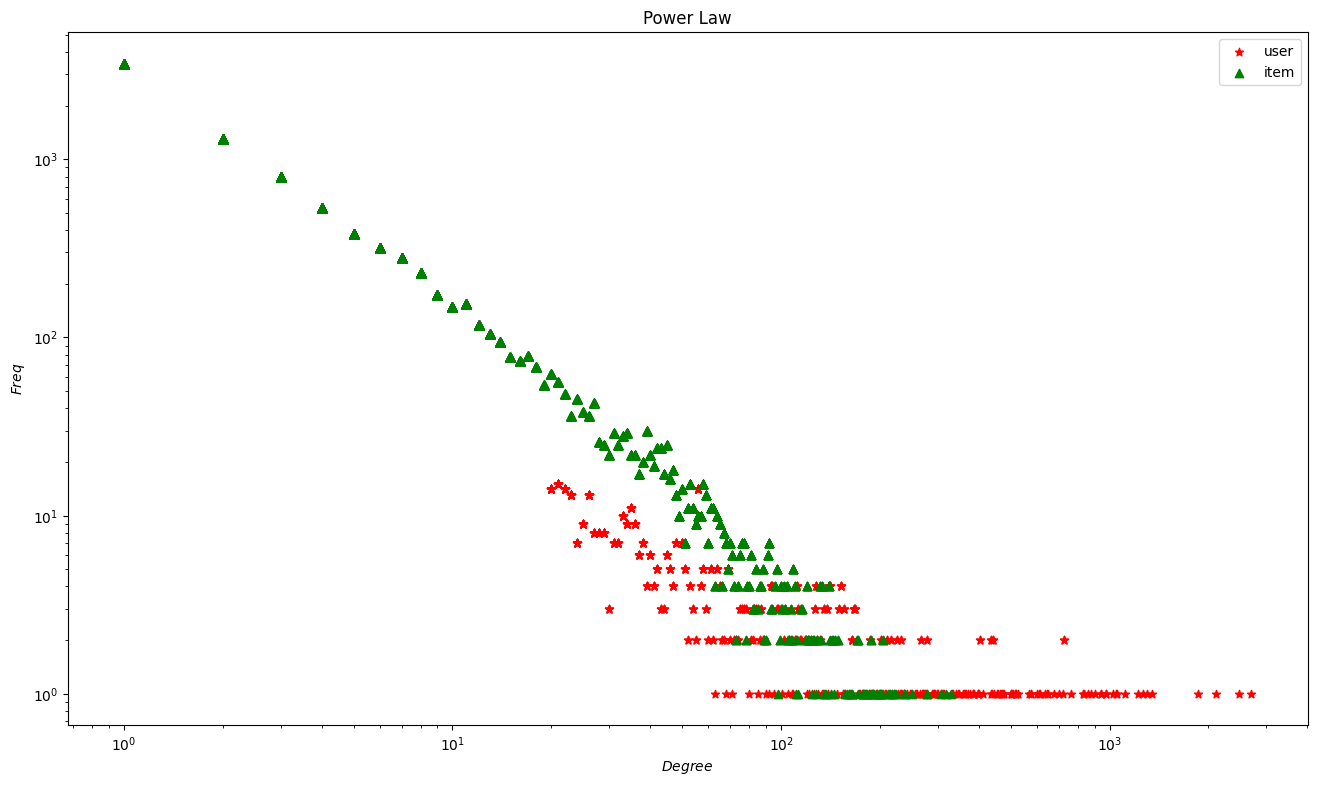

In [242]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

ax.scatter(user_count, [user_count.count(i) for i in user_count], color='r', marker='*')
ax.scatter(movie_count, [movie_count.count(i) for i in movie_count], color='g', marker='^')

# log scale
plt.yscale('log')
plt.xscale('log')

# labels
ax.set_xlabel('$Degree$')
ax.set_ylabel('$Freq$')
ax.set_title('Power Law')
ax.legend(['user', 'item'])

plt.savefig('/content/gdrive/MyDrive/power_law.svg', format='svg')
plt.plot()

In [240]:
# -------------------Declaring the Functions----------------------

# --------------------Updating Biases-----------------------------
def update_user_biase(data, user_vector, movie_vector, user_biases, movie_biases, lambd, gamma):
    for user_index, user_data in enumerate(data):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        bias_user = lambd * (ratings - (inner + movie_biases[indices]))
        user_biases[user_index] = bias_user.sum() / (lambd * len(user_data) + gamma)

def update_movie_biase(data, user_vector, movie_vector, user_biases, movie_biases, lambd, gamma):
    for movie_index, movie_data in enumerate(data):
        indices, ratings = zip(*movie_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[indices], movie_vector[movie_index])
        bias_movie = lambd * (ratings - (inner + user_biases[indices]))
        movie_biases[movie_index] = bias_movie.sum() / (lambd * len(movie_data) + gamma)

# --------------------Updating vectors-----------------------------

def update_user_vector(data, user_vector, movie_vector, user_biases, movie_biases, dims, lambd, tau, k):
    for m, user_data in enumerate(data):
        indices, ratings = zip(*user_data) if user_data else ([], [])
        indices = np.array(indices)
        matrix_left = np.dot(movie_vector[indices].T, movie_vector[indices])
        matrix_right = np.dot(ratings - user_biases[m] - movie_biases[indices], movie_vector[indices])
        user_vector[m] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)

def update_movie_vector(data, user_vector, movie_vector, user_biases, movie_biases, dims, lambd, tau, k):
    for n, movie_data in enumerate(data):
        indices, ratings = zip(*movie_data) if movie_data else ([], [])
        indices = np.array(indices)
        matrix_left = np.dot(user_vector[indices].T, user_vector[indices])
        matrix_right = np.dot(ratings - movie_biases[n] - user_biases[indices], user_vector[indices])
        movie_vector[n] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)


# ----------------------- loss functions --------------------------

def loss_function_biases(data_u, lambd, tau, gamma):
    loss = 0
    for user_index, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        loss += np.sum((ratings - (user_biases[user_index] + movie_biases[indices]))**2)
    reg_user = np.sum(np.einsum('ij,ij->i', user_vector, user_vector))
    reg_movie = np.sum(np.einsum('ij,ij->i', movie_vector, movie_vector))
    return (lambd/2) * loss + (tau/2) * reg_user + (tau/2) * reg_movie + (gamma/2) * (user_biases @ user_biases) + (gamma/2) * (movie_biases @ movie_biases)


def loss_function(data_u, lambd, tau, gamma):
    loss = 0
    for user_index, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        loss += np.sum((ratings - (inner + user_biases[user_index] + movie_biases[indices]))**2)
    reg_user = np.sum(np.einsum('ij,ij->i', user_vector, user_vector))
    reg_movie = np.sum(np.einsum('ij,ij->i', movie_vector, movie_vector))
    return (lambd/2) * loss + (tau/2) * reg_user + (tau/2) * reg_movie + (gamma/2) * (user_biases @ user_biases) + (gamma/2) * (movie_biases @ movie_biases)


def calculate_rmse(data, user_vector, movie_vector, user_biases, movie_biases):
    rmse = 0.0
    num_predictions = 0
    for user_index, user_data in enumerate(data):
        for movie_index, rating in user_data:
            prediction = (
                np.dot(user_vector[user_index], movie_vector[movie_index])
                + user_biases[user_index]
                + movie_biases[movie_index]
            )
            rmse += (rating - prediction) ** 2
            num_predictions += 1
    rmse = np.sqrt(rmse / num_predictions)
    return rmse

# SPlitting the data

In [5]:
def structure_data(arr):
    # Shuffle the data once
    np.random.seed(42)
    np.random.shuffle(arr)

    split_point = int(0.9 * len(arr))
    training_data = arr[:split_point]
    test_data = arr[split_point:]

    # Create dictionaries to map system IDs to indices
    system_user_to_user_dict = {}
    system_mov_to_mov_dict = {}

    for user_sys, movie_sys, _ in arr:
        # Handle user data structure
        if user_sys not in system_user_to_user_dict:
            system_user_to_user_dict[user_sys] = len(system_user_to_user_dict)

        # Handle movie data structure
        if movie_sys not in system_mov_to_mov_dict:
            system_mov_to_mov_dict[movie_sys] = len(system_mov_to_mov_dict)

    # Initialize lists for training and test data based on dictionary sizes
    data_by_user_train = [[] for _ in range(len(system_user_to_user_dict))]
    data_by_movie_train = [[] for _ in range(len(system_mov_to_mov_dict))]
    data_by_user_test = [[] for _ in range(len(system_user_to_user_dict))]
    data_by_movie_test = [[] for _ in range(len(system_mov_to_mov_dict))]

    for user_sys, movie_sys, rating in training_data:
        user_index = system_user_to_user_dict[user_sys]
        movie_index = system_mov_to_mov_dict[movie_sys]

        # Insert into the sparse user and item training matrices
        data_by_user_train[user_index].append((movie_index, float(rating)))
        data_by_movie_train[movie_index].append((user_index, float(rating)))

    for user_sys, movie_sys, rating in test_data:
        user_index = system_user_to_user_dict[user_sys]
        movie_index = system_mov_to_mov_dict[movie_sys]

        # Insert into the sparse user and item test matrices
        data_by_user_test[user_index].append((movie_index, float(rating)))
        data_by_movie_test[movie_index].append((user_index, float(rating)))

    return data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test

In [6]:

chunk_size = 100000
chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

# Create a ThreadPoolExecutor with the specified number of threads
num_threads = 40  # Change this to the number of threads you want to use

# Initialize lists to store the results
U_train = []
V_train = []
U_test = []
V_test = []

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i, chunk in enumerate(chunks):
        # Print the chunk index and the length of data processed so far
        print(f"Processing chunk {i + 1}/{len(chunks)}, Total data processed: {len(U_train)}")

        future = executor.submit(structure_data, chunk)
        data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test = future.result()

        # Extend the combined lists with the results
        U_train.extend(data_by_user_train)
        V_train.extend(data_by_movie_train)
        U_test.extend(data_by_user_test)
        V_test.extend(data_by_movie_test)

Processing chunk 1/2, Total data processed: 0
Processing chunk 2/2, Total data processed: 610


In [ ]:
print(f'U_train: {len(U_train)},\nU_test: {len(U_test)}, \nV_train: {len(V_train)}, \nV_test: {len(V_test)}')

U_train: 611,
U_test: 611, 
V_train: 10405, 
V_test: 10405


# Model training

In [ ]:
def model_zero(X_train, XX_train, dims):
    # Initialize model parameters
    user_vector = np.random.rand(len(X_train), dims)
    movie_vector = np.random.rand(len(XX_train), dims)
    user_biases = np.zeros((len(U_train)))
    movie_biases = np.zeros((len(V_train)))

    return user_vector, movie_vector, user_biases, movie_biases

def train_model(U_train, user_vector, movie_vector, user_biases, movie_biases, k, lambd, tau, gamma=0.01, epochs=30,
                learning_rate=0.01):
    display_epochs = [1, 10, 20, 30]
    rmse = []

    for epoch in range(epochs):
        for user_index, user_data in enumerate(U_train):
            for movie_index, rating in user_data:
                prediction = (
                        user_vector[user_index] @ movie_vector[movie_index] + user_biases[user_index] + movie_biases[
                    movie_index])

                error = rating - prediction
                user_vector[user_index] += learning_rate * (
                        error * movie_vector[movie_index] - lambd * user_vector[user_index])
                movie_vector[movie_index] += learning_rate * (
                        error * user_vector[user_index] - lambd * movie_vector[movie_index])
                user_biases[user_index] += learning_rate * (error - tau * user_biases[user_index])
                movie_biases[movie_index] += learning_rate * (error - tau * movie_biases[movie_index])

        rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
        rmse.append(rmse_train)
        if epoch + 1 in display_epochs:
            print(f"Epoch {epoch + 1}/{epochs}, RMSE (Train): {rmse_train:.4f}")

    return user_vector, movie_vector, user_biases, movie_biases

# def train_model(U_train, user_vector, movie_vector, user_biases, movie_biases, k, lambd, tau, gamma=0.01, epochs=30,
#                 learning_rate=0.01):
#     display_epochs = [1, 10, 20, 30]
#     rmse = []

#     for epoch in range(epochs):
#         # Update user and movie biases
#         update_user_biase(U_train, user_vector, movie_vector, user_biases, movie_biases, lambd, gamma)
#         update_movie_biase(V_train, user_vector, movie_vector, user_biases, movie_biases, lambd, gamma)
#         #
#         update_user_vector(U_train, user_vector, movie_vector, user_biases, movie_biases, k, lambd, tau, k)
#         update_movie_vector(V_train, user_vector, movie_vector, user_biases, movie_biases, k, lambd, tau, k)

#         #
#         rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
#         rmse.append(rmse_train)
#         if epoch + 1 in display_epochs:
#             print(f"Epoch {epoch + 1}/{epochs}, RMSE (Train): {rmse_train:.4f}")

#     return user_vector, movie_vector, user_biases, movie_biases

# Finding the best hyperparams

In [ ]:
from itertools import product
from multiprocessing import Pool

k_values = [5, 10, 20]
lambda_values = [0.01, 0.1, 1.0]
tau_values = [0.01, 0.1, 1.0]

def evaluate_hyperparameters(params):
    k, lambd, tau = params
    user_vector, movie_vector, user_biases, movie_biases = model_zero(U_train, V_train, k)
    user_vector, movie_vector, user_biases, movie_biases = train_model(U_train, user_vector, movie_vector, user_biases, movie_biases,
                                                                         k, lambd, tau, gamma=0.01, epochs=30, learning_rate=0.01)
    rmse = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
    return k, lambd, tau, rmse

if __name__ == "__main__":
    best_rmse = float('inf')
    best_params = None

    # Use a multiprocessing Pool for parallel execution
    with Pool(processes=4) as pool:  # Adjust the number of processes as needed
        hyperparameter_combinations = list(product(k_values, lambda_values, tau_values))
        results = pool.map(evaluate_hyperparameters, hyperparameter_combinations)

    for k, lambd, tau, rmse in results:
        print("Hyperparameters (k={}, lambda={}, tau={}): RMSE = {}".format(k, lambd, tau, rmse))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (k, lambd, tau)

    print('-----------------------------------------------------------------------------------------')
    print('The best model has: k= {}, lambda= {}, tau= {}'.format(best_params[0], best_params[1], best_params[2]))


ValueError: ignored

In [ ]:
# from itertools import product
# from concurrent.futures import ProcessPoolExecutor  # Use ProcessPoolExecutor for parallel execution

# def train_and_evaluate_model(params):
#     k, lambd, tau = params
#     user_vector, movie_vector, user_biases, movie_biases = model_zero(U_train, V_train, k)
#     user_vector, movie_vector, user_biases, movie_biases = train_model(U_train, user_vector, movie_vector, user_biases, movie_biases,
#                                                                      k, lambd, tau, gamma=0.01, epochs=30, learning_rate=0.01)
#     rmse = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)

#     print("Hyperparameters (k={}, lambda={}, tau={}): RMSE = {}".format(k, lambd, tau, rmse))

#     return k, lambd, tau, rmse

# # Specify the number of CPU cores you want to utilize
# num_workers = 20  # Change this to the number of CPU cores you want to use

# k_values = [5, 10, 20]
# lambda_values = [0.01, 0.1, 1.0]
# tau_values = [0.01, 0.1, 1.0]

# best_rmse = float('inf')
# best_params = None

# # Create a ProcessPoolExecutor with the specified number of workers (CPU cores)
# with ProcessPoolExecutor(max_workers=num_workers) as executor:
#     # Use the product function to generate parameter combinations
#     param_combinations = list(product(k_values, lambda_values, tau_values))
#     # Submit tasks to the executor and get a list of futures
#     futures = [executor.submit(train_and_evaluate_model, params) for params in param_combinations]

#     # Retrieve results from the futures
#     results = [future.result() for future in futures]

# for k, lambd, tau, rmse in results:
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = (k, lambd, tau)

# print('-----------------------------------------------------------------------------------------')
# print('The best model has: k= {}, lambda= {}, tau= {}'.format(best_params[0], best_params[1], best_params[2]))


Epoch 1/30, RMSE (Train): 0.9254
Epoch 1/30, RMSE (Train): 0.9075
Epoch 1/30, RMSE (Train): 0.9846
Epoch 1/30, RMSE (Train): 1.2186
Epoch 1/30, RMSE (Train): 1.1478
Epoch 1/30, RMSE (Train): 0.9761
Epoch 1/30, RMSE (Train): 1.0660Epoch 1/30, RMSE (Train): 1.0503
Epoch 1/30, RMSE (Train): 1.1248
Epoch 1/30, RMSE (Train): 1.0250Epoch 1/30, RMSE (Train): 0.9076


Epoch 1/30, RMSE (Train): 0.9247
Epoch 1/30, RMSE (Train): 1.0145
Epoch 1/30, RMSE (Train): 0.9288
Epoch 1/30, RMSE (Train): 0.9111
Epoch 1/30, RMSE (Train): 1.0168
Epoch 1/30, RMSE (Train): 0.9569
Epoch 1/30, RMSE (Train): 1.0752
Epoch 1/30, RMSE (Train): 1.0247
Epoch 1/30, RMSE (Train): 0.9567
Epoch 10/30, RMSE (Train): 0.8184
Epoch 10/30, RMSE (Train): 0.7688
Epoch 10/30, RMSE (Train): 0.7713
Epoch 10/30, RMSE (Train): 0.7675
Epoch 10/30, RMSE (Train): 0.8776
Epoch 10/30, RMSE (Train): 1.2491
Epoch 10/30, RMSE (Train): 1.2202
Epoch 10/30, RMSE (Train): 0.8444
Epoch 10/30, RMSE (Train): 0.8023
Epoch 10/30, RMSE (Train): 0.7990


In [ ]:
# Sample hyperparameters
learning_rate = 0.01
num_epochs = 50
lambd = 1
tau = 0.01
gamma = 0.01
dims = 10

# Initialize model parameters
user_vector = np.random.rand(len(U_train), dims)
movie_vector = np.random.rand(len(V_train), dims)
user_biases = np.zeros(len(U_train))
movie_biases = np.zeros(len(V_train))


rmse_train_history = []
rmse_test_history = []

for epoch in range(num_epochs):
    # Update user and movie biases
    update_user_biase(U_train, lambd, gamma)
    update_movie_biase(V_train, lambd, gamma)

    # Update user and movie vectors
    update_user_vector(U_train, lambd, tau, dims)
    update_movie_vector(V_train, lambd, tau, dims)

    # Calculate RMSE for U_train and U_test
    rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
    rmse_test = calculate_rmse(U_test, user_vector, movie_vector, user_biases, movie_biases)

    rmse_train_history.append(rmse_train)
    rmse_test_history.append(rmse_test)

    print(f"Epoch {epoch+1}/{num_epochs}, RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")


# Plot RMSE values
plt.figure(figsize=(10, 5))

plt.plot(rmse_train_history, label='Training RMSE', color='b')
plt.plot(rmse_test_history, label='Testing RMSE', color='r')

plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.savefig('RMSE_new_plot.eps', format='eps')
plt.show()

ValueError: ignored

In [ ]:
# import numpy as np

# # Sample hyperparameters
# learning_rate = 0.01
# num_epochs = 50
# lamda = 1
# tau = 0.01
# gamma = 0.01
# dims = 10

# # Initialize model parameters
# user_vector = np.random.rand(len(U_train), dims)
# movie_vector = np.random.rand(len(V_train), dims)
# bias_user = np.zeros(len(U_train))
# bias_movie = np.zeros(len(V_train))

# # Initialize lists to store RMSE values during training
# rmse_train_history = []
# rmse_test_history = []

# # Define prediction function
# def predict(user_vector, movie_vector, bias_user, bias_movie, user_index, movie_index):
#     prediction = np.dot(user_vector[user_index], movie_vector[movie_index]) + bias_user[user_index] + bias_movie[movie_index]
#     return prediction

# # Training loop
# for epoch in range(num_epochs):
#     for user_index, user_data in enumerate(U_train):
#         movie_indices, ratings = zip(*user_data)
#         movie_indices = np.array(movie_indices)

#         # Predict ratings for all movies in a vectorized manner
#         predictions = np.dot(user_vector[user_index], movie_vector[movie_indices].T) + bias_user[user_index] + bias_movie[movie_indices]

#         # Calculate errors (residuals)
#         errors = ratings - predictions

#         # Update user and movie vectors using SGD
#         user_vector[user_index] += learning_rate * (np.dot(errors, movie_vector[movie_indices]) - lamda * user_vector[user_index])
#         movie_vector[movie_indices] += learning_rate * (errors[:, np.newaxis] * user_vector[user_index] - lamda * movie_vector[movie_indices])

#         # Update user and movie biases
#         bias_user[user_index] += learning_rate * (errors - tau * bias_user[user_index])
#         bias_movie[movie_indices] += learning_rate * (errors - tau * bias_movie[movie_indices])

#     # Calculate RMSE for U_train and U_test
#     rmse_train = np.sqrt(np.mean([(ratings - predict(user_vector, movie_vector, bias_user, bias_movie, user_index, movie_index)) ** 2
#                                 for user_index, user_data in enumerate(U_train) for movie_index, ratings in user_data]))
#     rmse_test = np.sqrt(np.mean([(ratings - predict(user_vector, movie_vector, bias_user, bias_movie, user_index, movie_index)) ** 2
#                                for user_index, user_data in enumerate(U_test) for movie_index, ratings in user_data]))

#     rmse_train_history.append(rmse_train)
#     rmse_test_history.append(rmse_test)

#     print(f"Epoch {epoch+1}/{num_epochs}, RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")


# Parallel + chinks

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Sample hyperparameters
learning_rate = 0.01
num_epochs = 50
lamda = 1
tau = 0.01
gamma = 0.01
dims = 10

# Initialize model parameters
user_vector = np.random.rand(len(U_train), dims)
movie_vector = np.random.rand(len(V_train), dims)
user_biases = np.zeros(len(U_train))
movie_biases = np.zeros(len(V_train))

# Define a function for training a chunk of data
def train_chunk(chunk):
    chunk_user_vector = np.copy(user_vector)
    chunk_movie_vector = np.copy(movie_vector)
    chunk_bias_user = np.copy(user_biases)
    chunk_bias_movie = np.copy(movie_biases)

    for epoch in range(num_epochs):
        for user_index, user_data in enumerate(chunk):
            for movie_index, rating in user_data:
                # Predict the rating
                prediction = (chunk_user_vector[user_index] @ chunk_movie_vector[movie_index] + chunk_bias_user[user_index] + chunk_bias_movie[movie_index])

                # Calculate the error (residual)
                error = rating - prediction

                # Update user and movie vectors using SGD
                chunk_user_vector[user_index] += learning_rate * (error * chunk_movie_vector[movie_index] - lamda * chunk_user_vector[user_index])
                chunk_movie_vector[movie_index] += learning_rate * (error * chunk_user_vector[user_index] - lamda * chunk_movie_vector[movie_index])

                # Update user and movie biases
                chunk_bias_user[user_index] += learning_rate * (error - tau * chunk_bias_user[user_index])
                chunk_bias_movie[movie_index] += learning_rate * (error - tau * chunk_bias_movie[movie_index])

    return chunk_user_vector, chunk_movie_vector, chunk_bias_user, chunk_bias_movie

# Split the training data into chunks
chunk_size = 10  # Adjust the chunk size as needed
chunks = [U_train[i:i + chunk_size] for i in range(0, len(U_train), chunk_size)]

rmse_train_history = []
rmse_test_history = []

# Initialize ThreadPoolExecutor
num_threads = 8  # Adjust the number of threads as needed
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    chunk_futures = [executor.submit(train_chunk, chunk) for chunk in chunks]

    # Collect the results from the futures
    results = [future.result() for future in chunk_futures]

    # Combine the results from all chunks
    user_vector, movie_vector, bias_user, bias_movie = zip(*results)
    user_vector = np.vstack(user_vector)
    movie_vector = np.vstack(movie_vector)
    bias_user = np.hstack(bias_user)
    bias_movie = np.hstack(bias_movie)

    # Rest of your code (RMSE calculation, predictions, etc.)
    rmse_train = calculate_rmse(U_train, user_vector, movie_vector, bias_user, bias_movie)
    rmse_test = calculate_rmse(U_test, user_vector, movie_vector, bias_user, bias_movie)

    rmse_train_history.append(rmse_train)
    rmse_test_history.append(rmse_test)

    print(f"RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")

# Plot RMSE values
plt.figure(figsize=(10, 5))

plt.plot(rmse_train_history, label='Training RMSE', color='b')
plt.plot(rmse_test_history, label='Testing RMSE', color='r')

plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.savefig('RMSE_new_plot.eps', format='eps')
plt.show()

# Predict on U_test
def predict(user_vector, movie_vector, bias_user, bias_movie, user_index, movie_index):
    prediction = (user_vector[user_index] @ movie_vector[movie_index] + bias_user[user_index] + bias_movie[movie_index])
    return prediction

# Make predictions on U_test
predictions = []

for user_index, user_data in enumerate(U_test):
    for movie_index, _ in user_data:
        prediction = predict(user_vector, movie_vector, bias_user, bias_movie, user_index, movie_index)
        predictions.append(prediction)

# Evaluate the model's performance (e.g., calculate RMSE)
actual_ratings = [rating for user_data in U_test for _, rating in user_data]
predicted_ratings = predictions
rmse = np.sqrt(np.mean([(actual - predicted) ** 2 for actual, predicted in zip(actual_ratings, predicted_ratings)]))

print(f"RMSE on U_test: {rmse:.4f}")

In [ ]:
import numpy as np
from multiprocessing import Pool
from itertools import product


def model_zero(U_train, V_train, k):
    # Initialize model parameters
    user_vector = np.random.rand(len(U_train), k)
    movie_vector = np.random.rand(len(V_train), k)
    user_biases = np.zeros(len(U_train))
    movie_biases = np.zeros(len(V_train))
    return user_vector, movie_vector, user_biases, movie_biases


def train_model(U_train, user_vector, movie_vector, user_biases, movie_biases, k, lambd, tau, epochs=30,
                learning_rate=0.01):
    display_epochs = [1, 10, 20, 30]
    rmse = []

    for epoch in range(epochs):
        for user_index, user_data in enumerate(U_train):
            for movie_index, rating in user_data:
                prediction = (
                        user_vector[user_index] @ movie_vector[movie_index] + user_biases[user_index] + movie_biases[
                    movie_index])

                error = rating - prediction
                user_vector[user_index] += learning_rate * (
                        error * movie_vector[movie_index] - lambd * user_vector[user_index])
                movie_vector[movie_index] += learning_rate * (
                        error * user_vector[user_index] - lambd * movie_vector[movie_index])
                user_biases[user_index] += learning_rate * (error - tau * user_biases[user_index])
                movie_biases[movie_index] += learning_rate * (error - tau * movie_biases[movie_index])

        rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
        rmse.append(rmse_train)
        if epoch + 1 in display_epochs:
            print(f"Epoch {epoch + 1}/{epochs}, RMSE (Train): {rmse_train:.4f}")

    return user_vector, movie_vector, user_biases, movie_biases


def update_user_biases(data_u, lambd, gamma, user_vector, movie_vector, user_biases, movie_biases):
    for user_index, user_data in enumerate(data_u):
        if not user_data:
            continue
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        bias_user = lambd * (ratings - (inner + movie_biases[indices]))
        user_biases[user_index] = bias_user.sum() / (lambd * len(user_data) + gamma)


def update_movie_biases(data_v, lambd, gamma, user_vector, movie_vector, user_biases, movie_biases):
    for movie_index, movie_data in enumerate(data_v):
        if not movie_data:
            continue
        indices, ratings = zip(*movie_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[indices], movie_vector[movie_index])
        bias_movie = lambd * (ratings - (inner + user_biases[indices]))
        movie_biases[movie_index] = bias_movie.sum() / (lambd * len(movie_data) + gamma)


def update_user_vectors(data_u, lambd, tau, dims, user_vector, movie_vector, user_biases, movie_biases):
    for m, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data) if user_data else ([], [])
        if not indices:
            continue
        indices = np.array(indices)
        matrix_left = np.dot(movie_vector[indices].T, movie_vector[indices])
        matrix_right = np.dot(ratings - user_biases[m] - movie_biases[indices], movie_vector[indices])
        user_vector[m] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)


def update_movie_vectors(data_v, lambd, tau, dims, user_vector, movie_vector, user_biases, movie_biases):
    for n, movie_data in enumerate(data_v):
        indices, ratings = zip(*movie_data) if movie_data else ([], [])
        if not indices:
            continue
        indices = np.array(indices)
        matrix_left = np.dot(user_vector[indices].T, user_vector[indices])
        matrix_right = np.dot(ratings - movie_biases[n] - user_biases[indices], user_vector[indices])
        movie_vector[n] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)


def loss_function_biases(data_u, lambd, tau, gamma, user_vector, movie_vector, user_biases, movie_biases):
    loss = 0
    for user_index, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        loss += np.sum((ratings - (user_biases[user_index] + movie_biases[indices])) ** 2)
    reg_user = np.sum(np.einsum('ij,ij->i', user_vector, user_vector))
    reg_movie = np.sum(np.einsum('ij,ij->i', movie_vector, movie_vector))
    return (lambd / 2) * loss + (tau / 2) * reg_user + (tau / 2) * reg_movie + (gamma / 2) * (
            user_biases @ user_biases) + (gamma / 2) * (movie_biases @ movie_biases)


def loss_function(data_u, lambd, tau, gamma, user_vector, movie_vector, user_biases, movie_biases):
    loss = 0
    for user_index, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        loss += np.sum((ratings - (inner + user_biases[user_index] + movie_biases[indices])) ** 2)
    reg_user = np.sum(np.einsum('ij,ij->i', user_vector, user_vector))
    reg_movie = np.sum(np.einsum('ij,ij->i', movie_vector, movie_vector))
    return (lambd / 2) * loss + (tau / 2) * reg_user + (tau / 2) * reg_movie + (gamma / 2) * (
            user_biases @ user_biases) + (gamma / 2) * (movie_biases @ movie_biases)


def calculate_rmse(data, user_vector, movie_vector, user_biases, movie_biases):
    rmse = 0.0
    num_predictions = 0
    for user_index, user_data in enumerate(data):
        for movie_index, rating in user_data:
            prediction = (
                    np.dot(user_vector[user_index], movie_vector[movie_index])
                    + user_biases[user_index]
                    + movie_biases[movie_index]
            )
            rmse += (rating - prediction) ** 2
            num_predictions += 1
    rmse = np.sqrt(rmse / num_predictions)
    return rmse


def train_and_evaluate(params):
    k, lambd, tau = params
    user_vector, movie_vector, user_biases, movie_biases = model_zero(U_train, V_train, k)
    user_vector, movie_vector, user_biases, movie_biases = train_model(U_train, user_vector, movie_vector,
                                                                       user_biases, movie_biases, k, lambd,
                                                                       tau, epochs=30, learning_rate=0.01)
    rmse = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
    return k, lambd, tau, rmse


if __name__ == "__main__":
    # Load your dataset and preprocess it (ensure you have user IDs, movie IDs, and ratings)

    # Define hyperparameter values suitable for your dataset
    k_values = [5, 10, 20]
    lambda_values = [0.01, 0.1, 1.0]
    tau_values = [0.01, 0.1, 1.0]

    best_rmse = float('inf')
    best_params = None
    param_combinations = list(product(k_values, lambda_values, tau_values))

    with Pool(processes=12) as pool:
        results = pool.map(train_and_evaluate, [(params) for params in param_combinations])

    for k, lambd, tau, rmse in results:
        print("Hyperparameters (k={}, lambda={}, tau={}): RMSE = {}".format(k, lambd, tau, rmse))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (k, lambd, tau)

    print('-----------------------------------------------------------------------------------------')
    print('The best model has: k={}, lambda={}, tau={}'.format(best_params[0], best_params[1], best_params[2]))

In [ ]:
np.random.rand(len(user_vector[0]))[1]

0.5742593975235993

# Training the model

In [ ]:
import numpy as np
from multiprocessing import Pool
# from itertools import product

def structure_data(arr):
    # Shuffle the data
    MY_SEED = 42
    np.random.seed(MY_SEED)
    np.random.shuffle(arr)
    split_point = int(0.9 * len(arr))

    # Initialize all the data structures
    system_user_to_user_dict = {}
    user_to_system_user = []
    system_mov_to_mov_dict = {}
    mov_to_system_mov = []

    # First build the mappings.
    for index in range(len(arr)):
        user_sys = arr[index][0]
        movie_sys = arr[index][1]

        # Take care of the user data structure
        if user_sys not in system_user_to_user_dict:
            user_to_system_user.append(user_sys)
            system_user_to_user_dict[user_sys] = len(system_user_to_user_dict)

        # Take care of the movie data structure
        if movie_sys not in system_mov_to_mov_dict:
            mov_to_system_mov.append(movie_sys)
            system_mov_to_mov_dict[movie_sys] = len(system_mov_to_mov_dict)

    # Initialize with empty lists all the training data.
    data_by_user_train = [[] for _ in range(len(user_to_system_user))]
    data_by_movie_train = [[] for _ in range(len(mov_to_system_mov))]

    # Initialize with empty lists all the test data.
    data_by_user_test = [[] for _ in range(len(user_to_system_user))]
    data_by_movie_test = [[] for _ in range(len(mov_to_system_mov))]

    # Create all the data structure using a loop
    for index in range(len(arr)):
        user_sys = arr[index][0]
        movie_sys = arr[index][1]
        rating = arr[index][2]

        user_index = system_user_to_user_dict[user_sys]
        movie_index = system_mov_to_mov_dict[movie_sys]

        if index < split_point:
            # Insert into the sparse user and item training matrices.
            data_by_user_train[user_index].append((movie_index, float(rating)))
            data_by_movie_train[movie_index].append((user_index, float(rating)))
        else:
            # Insert into the sparse user and item test matrices.
            data_by_user_test[user_index].append((movie_index, float(rating)))
            data_by_movie_test[movie_index].append((user_index, float(rating)))

    return system_user_to_user_dict, user_to_system_user, system_mov_to_mov_dict, mov_to_system_mov, data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test


def model_zero(U_train, V_train, k):
    # Initialize model parameters
    user_vector = np.random.rand(len(U_train), k)
    movie_vector = np.random.rand(len(V_train), k)
    user_biases = np.zeros(len(U_train))
    movie_biases = np.zeros(len(V_train))
    return user_vector, movie_vector, user_biases, movie_biases


def train_model(U_train, user_vector, movie_vector, user_biases, movie_biases, k, lambd, tau, epochs=30,
                learning_rate=0.01):
    display_epochs = [1, 10, 20, 30]
    rmse = []

    for epoch in range(epochs):
        for user_index, user_data in enumerate(U_train):
            for movie_index, rating in user_data:
                prediction = (
                        user_vector[user_index] @ movie_vector[movie_index] + user_biases[user_index] + movie_biases[
                    movie_index])

                error = rating - prediction
                user_vector[user_index] += learning_rate * (
                        error * movie_vector[movie_index] - lambd * user_vector[user_index])
                movie_vector[movie_index] += learning_rate * (
                        error * user_vector[user_index] - lambd * movie_vector[movie_index])
                user_biases[user_index] += learning_rate * (error - tau * user_biases[user_index])
                movie_biases[movie_index] += learning_rate * (error - tau * movie_biases[movie_index])

        rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
        rmse.append(rmse_train)
        if epoch + 1 in display_epochs:
            print(f"Epoch {epoch + 1}/{epochs}, RMSE (Train): {rmse_train:.4f}")

    return user_vector, movie_vector, user_biases, movie_biases


def update_user_biases(data_u, lambd, gamma, user_vector, movie_vector, user_biases, movie_biases):
    for user_index, user_data in enumerate(data_u):
        if not user_data:
            continue
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        bias_user = lambd * (ratings - (inner + movie_biases[indices]))
        user_biases[user_index] = bias_user.sum() / (lambd * len(user_data) + gamma)


def update_movie_biases(data_v, lambd, gamma, user_vector, movie_vector, user_biases, movie_biases):
    for movie_index, movie_data in enumerate(data_v):
        if not movie_data:
            continue
        indices, ratings = zip(*movie_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[indices], movie_vector[movie_index])
        bias_movie = lambd * (ratings - (inner + user_biases[indices]))
        movie_biases[movie_index] = bias_movie.sum() / (lambd * len(movie_data) + gamma)


def update_user_vectors(data_u, lambd, tau, dims, user_vector, movie_vector, user_biases, movie_biases):
    for m, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data) if user_data else ([], [])
        if not indices:
            continue
        indices = np.array(indices)
        matrix_left = np.dot(movie_vector[indices].T, movie_vector[indices])
        matrix_right = np.dot(ratings - user_biases[m] - movie_biases[indices], movie_vector[indices])
        user_vector[m] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)


def update_movie_vectors(data_v, lambd, tau, dims, user_vector, movie_vector, user_biases, movie_biases):
    for n, movie_data in enumerate(data_v):
        indices, ratings = zip(*movie_data) if movie_data else ([], [])
        if not indices:
            continue
        indices = np.array(indices)
        matrix_left = np.dot(user_vector[indices].T, user_vector[indices])
        matrix_right = np.dot(ratings - movie_biases[n] - user_biases[indices], user_vector[indices])
        movie_vector[n] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)


def loss_function_biases(data_u, lambd, tau, gamma, user_vector, movie_vector, user_biases, movie_biases):
    loss = 0
    for user_index, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        loss += np.sum((ratings - (user_biases[user_index] + movie_biases[indices])) ** 2)
    reg_user = np.sum(np.einsum('ij,ij->i', user_vector, user_vector))
    reg_movie = np.sum(np.einsum('ij,ij->i', movie_vector, movie_vector))
    return (lambd / 2) * loss + (tau / 2) * reg_user + (tau / 2) * reg_movie + (gamma / 2) * (
            user_biases @ user_biases) + (gamma / 2) * (movie_biases @ movie_biases)


def loss_function(data_u, lambd, tau, gamma, user_vector, movie_vector, user_biases, movie_biases):
    loss = 0
    for user_index, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        loss += np.sum((ratings - (inner + user_biases[user_index] + movie_biases[indices])) ** 2)
    reg_user = np.sum(np.einsum('ij,ij->i', user_vector, user_vector))
    reg_movie = np.sum(np.einsum('ij,ij->i', movie_vector, movie_vector))
    return (lambd / 2) * loss + (tau / 2) * reg_user + (tau / 2) * reg_movie + (gamma / 2) * (
            user_biases @ user_biases) + (gamma / 2) * (movie_biases @ movie_biases)


def calculate_rmse(data, user_vector, movie_vector, user_biases, movie_biases):
    rmse = 0.0
    num_predictions = 0
    for user_index, user_data in enumerate(data):
        for movie_index, rating in user_data:
            prediction = (
                    np.dot(user_vector[user_index], movie_vector[movie_index])
                    + user_biases[user_index]
                    + movie_biases[movie_index]
            )
            rmse += (rating - prediction) ** 2
            num_predictions += 1
    rmse = np.sqrt(rmse / num_predictions)
    return rmse


def train_with_best_params(params, U_train_set, V_train_set):
    k, lambd, tau = params
    user_vector, movie_vector, user_biases, movie_biases = model_zero(U_train_set, V_train_set, k)
    user_vector, movie_vector, user_biases, movie_biases = train_model(U_train_set, user_vector, movie_vector,
                                                                       user_biases, movie_biases, k, lambd,
                                                                       tau, epochs=30, learning_rate=0.01)
    rmse = calculate_rmse(U_train_set, user_vector, movie_vector, user_biases, movie_biases)
    return k, lambd, tau, rmse


if __name__ == "__main__":
    # Load your data here
    with Pool(processes=8) as pool:
        # Parallelize the structure_data function
        processed_data = pool.map(structure_data, [data])

    # Separate the results from structure_data
    (
        system_user_to_user_dict,
        user_to_system_user,
        system_mov_to_mov_dict,
        mov_to_system_mov,
        U_train,
        V_train,
        U_test,
        V_test,
    ) = processed_data[0]  # Assuming you only have one dataset

    # Define the best hyperparameters
    best_params = (5, 0.01, 0.01)  # Replace with your best hyperparameters

    # Define your datasets if you have multiple
    U_train_datasets = U_train  # Replace with your training datasets
    V_train_datasets = V_train  # Replace with your training datasets

    trained_models = []  # To store the trained models

    with Pool(processes=4) as pool:
        best_results = pool.apply(train_with_best_params, (best_params, U_train, V_train))

    print("Best Hyperparameters (k={}, lambda={}, tau={}): RMSE = {}".format(*best_results))

Epoch 1/30, RMSE (Train): 1.0680
Epoch 10/30, RMSE (Train): 0.7878
Epoch 20/30, RMSE (Train): 0.7347
Epoch 30/30, RMSE (Train): 0.6971
Best Hyperparameters (k=5, lambda=0.01, tau=0.01): RMSE = 0.6971136039347103


Epoch 1/100, RMSE (Train): 1.8202, RMSE (Test): 1.8221
Epoch 10/100, RMSE (Train): 0.9064, RMSE (Test): 1.1616
Epoch 20/100, RMSE (Train): 0.7575, RMSE (Test): 1.1009
Epoch 30/100, RMSE (Train): 0.6916, RMSE (Test): 1.0824
Epoch 40/100, RMSE (Train): 0.6508, RMSE (Test): 1.0746
Epoch 50/100, RMSE (Train): 0.6205, RMSE (Test): 1.0710
Epoch 60/100, RMSE (Train): 0.5954, RMSE (Test): 1.0695
Epoch 70/100, RMSE (Train): 0.5732, RMSE (Test): 1.0693
Epoch 80/100, RMSE (Train): 0.5528, RMSE (Test): 1.0697
Epoch 90/100, RMSE (Train): 0.5339, RMSE (Test): 1.0707
Epoch 100/100, RMSE (Train): 0.5162, RMSE (Test): 1.0721


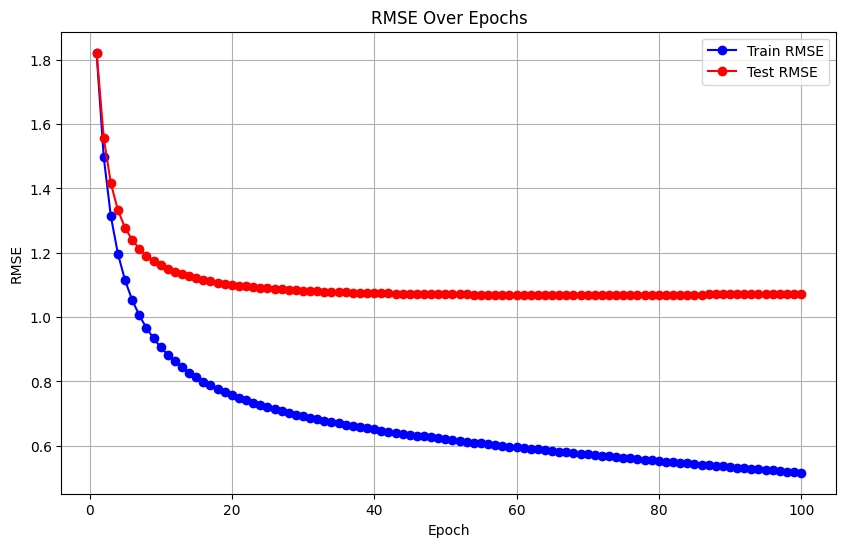

In [ ]:
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt

# # Define the data type for dtype_
# dtype_ = np.dtype([("userId", int), ("movieId", int), ("rating", float)])

# # Read your data from the file
# data = np.loadtxt("data/ratings_25m.csv", delimiter=",", skiprows=1, dtype=dtype_, usecols=[0, 1, 2])

# Function to structure your data
def structure_data(arr):
    # Shuffle the data
    MY_SEED = 42
    np.random.seed(MY_SEED)
    np.random.shuffle(arr)
    split_point = int(0.9 * len(arr))

    # Initialize all the data structures
    system_user_to_user_dict = {}
    user_to_system_user = []
    system_mov_to_mov_dict = {}
    mov_to_system_mov = []

    # First build the mappings.
    for index in range(len(arr)):
        user_sys = arr[index][0]
        movie_sys = arr[index][1]

        # Take care of the user data structure
        if user_sys not in system_user_to_user_dict:
            user_to_system_user.append(user_sys)
            system_user_to_user_dict[user_sys] = len(system_user_to_user_dict)

        # Take care of the movie data structure
        if movie_sys not in system_mov_to_mov_dict:
            mov_to_system_mov.append(movie_sys)
            system_mov_to_mov_dict[movie_sys] = len(system_mov_to_mov_dict)

    # Initialize with empty lists all the training data.
    data_by_user_train = [[] for _ in range(len(user_to_system_user))]
    data_by_movie_train = [[] for _ in range(len(mov_to_system_mov))]

    # Initialize with empty lists all the test data.
    data_by_user_test = [[] for _ in range(len(user_to_system_user))]
    data_by_movie_test = [[] for _ in range(len(mov_to_system_mov))]

    # Create all the data structure using a loop
    for index in range(len(arr)):
        user_sys = arr[index][0]
        movie_sys = arr[index][1]
        rating = arr[index][2]

        user_index = system_user_to_user_dict[user_sys]
        movie_index = system_mov_to_mov_dict[movie_sys]

        if index < split_point:
            # Insert into the sparse user and item training matrices.
            data_by_user_train[user_index].append((movie_index, float(rating)))
            data_by_movie_train[movie_index].append((user_index, float(rating)))
        else:
            # Insert into the sparse user and item test matrices.
            data_by_user_test[user_index].append((movie_index, float(rating)))
            data_by_movie_test[movie_index].append((user_index, float(rating)))

    return system_user_to_user_dict, user_to_system_user, system_mov_to_mov_dict, mov_to_system_mov, data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test

# Function to create the initial model with random parameters
def model_zero(U_train, V_train, k):
    # Initialize model parameters
    user_vector = np.random.rand(len(U_train), k)
    movie_vector = np.random.rand(len(V_train), k)
    user_biases = np.zeros(len(U_train))
    movie_biases = np.zeros(len(V_train))
    return user_vector, movie_vector, user_biases, movie_biases

# Function to train the model
def train_model(U_train, user_vector, movie_vector, user_biases, movie_biases, k, lambd, tau, epochs=30, learning_rate=0.01):
    display_epochs = [1, 10, 20, 30]
    rmse = []

    for epoch in range(epochs):
        for user_index, user_data in enumerate(U_train):
            if user_data:  # Check if user_data is not empty
                for movie_index, rating in user_data:
                    prediction = (
                            user_vector[user_index] @ movie_vector[movie_index] + user_biases[user_index] + movie_biases[movie_index])

                    error = rating - prediction
                    user_vector[user_index] += learning_rate * (
                            error * movie_vector[movie_index] - lambd * user_vector[user_index])
                    movie_vector[movie_index] += learning_rate * (
                            error * user_vector[user_index] - lambd * movie_vector[movie_index])
                    user_biases[user_index] += learning_rate * (error - tau * user_biases[user_index])
                    movie_biases[movie_index] += learning_rate * (error - tau * movie_biases[movie_index])

        rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
        rmse.append(rmse_train)
        if epoch + 1 in display_epochs:
            print(f"Epoch {epoch + 1}/{epochs}, RMSE (Train): {rmse_train:.4f}")

    return user_vector, movie_vector, user_biases, movie_biases



# Function to update user biases
def update_user_biases(data_u, lambd, gamma, user_vector, movie_vector, user_biases, movie_biases):
    for user_index, user_data in enumerate(data_u):
        if not user_data:
            continue
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        bias_user = lambd * (ratings - (inner + movie_biases[indices]))
        user_biases[user_index] = bias_user.sum() / (lambd * len(user_data) + gamma)

# Function to update movie biases
def update_movie_biases(data_v, lambd, gamma, user_vector, movie_vector, user_biases, movie_biases):
    for movie_index, movie_data in enumerate(data_v):
        if not movie_data:
            continue
        indices, ratings = zip(*movie_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[indices], movie_vector[movie_index])
        bias_movie = lambd * (ratings - (inner + user_biases[indices]))
        movie_biases[movie_index] = bias_movie.sum() / (lambd * len(movie_data) + gamma)

# Function to update user vectors
def update_user_vectors(data_u, lambd, tau, dims, user_vector, movie_vector, user_biases, movie_biases):
    for m, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data) if user_data else ([], [])
        if not indices:
            continue
        indices = np.array(indices)
        matrix_left = np.dot(movie_vector[indices].T, movie_vector[indices])
        matrix_right = np.dot(ratings - user_biases[m] - movie_biases[indices], movie_vector[indices])
        user_vector[m] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)

# Function to update movie vectors
def update_movie_vectors(data_v, lambd, tau, dims, user_vector, movie_vector, user_biases, movie_biases):
    for n, movie_data in enumerate(data_v):
        indices, ratings = zip(*movie_data) if movie_data else ([], [])
        if not indices:
            continue
        indices = np.array(indices)
        matrix_left = np.dot(user_vector[indices].T, user_vector[indices])
        matrix_right = np.dot(ratings - movie_biases[n] - user_biases[indices], user_vector[indices])
        movie_vector[n] = np.linalg.solve(lambd * matrix_left + tau * np.eye(dims), lambd * matrix_right)

# Function to compute the loss function
def loss_function(data_u, lambd, tau, gamma, user_vector, movie_vector, user_biases, movie_biases):
    loss = 0
    for user_index, user_data in enumerate(data_u):
        indices, ratings = zip(*user_data)
        indices = np.array(indices)
        inner = np.dot(user_vector[user_index], movie_vector[indices].T)
        loss += np.sum((ratings - (inner + user_biases[user_index] + movie_biases[indices])) ** 2)
    reg_user = np.sum(np.einsum('ij,ij->i', user_vector, user_vector))
    reg_movie = np.sum(np.einsum('ij,ij->i', movie_vector, movie_vector))
    return (lambd / 2) * loss + (tau / 2) * reg_user + (tau / 2) * reg_movie + (gamma / 2) * (
            user_biases @ user_biases) + (gamma / 2) * (movie_biases @ movie_biases)

# Function to calculate RMSE
def calculate_rmse(data, user_vector, movie_vector, user_biases, movie_biases):
    rmse = 0.0
    num_predictions = 0
    for user_index, user_data in enumerate(data):
        for movie_index, rating in user_data:
            prediction = (
                    np.dot(user_vector[user_index], movie_vector[movie_index])
                    + user_biases[user_index]
                    + movie_biases[movie_index]
            )
            rmse += (rating - prediction) ** 2
            num_predictions += 1
    rmse = np.sqrt(rmse / num_predictions)
    return rmse


# Function to train with the best parameters
def train_with_best_params(params, U_train_set, V_train_set):
    k, lambd, tau = params
    user_vector, movie_vector, user_biases, movie_biases = model_zero(U_train_set, V_train_set, k)
    user_vector, movie_vector, user_biases, movie_biases = train_model(U_train_set, user_vector, movie_vector,
                                                                       user_biases, movie_biases, k, lambd,
                                                                       tau, epochs=30, learning_rate=0.01)
    rmse = calculate_rmse(U_train_set, user_vector, movie_vector, user_biases, movie_biases)
    return k, lambd, tau, rmse

if __name__ == "__main__":
    # Load your data here
    # data = np.loadtxt("data/ratings_25m.csv", delimiter=",", skiprows=1, dtype=dtype_, usecols=[0, 1, 2])

    # Split your data into smaller chunks
    chunk_size = 10000  # Adjust the chunk size as needed
    data_chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    best_params = (5, 0.1, 0.01)  # Replace with your best hyperparameters

    trained_models = []  # To store the trained models

    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        # Use executor.map to parallelize the work over data chunks
        # Parallelize the structure_data function
        processed_data = list(executor.map(structure_data, data_chunks))

        # Combine the results as needed
        (
            system_user_to_user_dict,
            user_to_system_user,
            system_mov_to_mov_dict,
            mov_to_system_mov,
            U_train,
            V_train,
            U_test,
            V_test,
        ) = processed_data[0]  # Assuming you only have one dataset

    # Training loop
    k, lambd, tau = best_params
    user_vector, movie_vector, user_biases, movie_biases = model_zero(U_train, V_train, k)

    epochs = 100
    learning_rate = 0.005
    display_epochs = [1, 10, 20, 30, 40 ,50 ,60 ,70 ,80 ,90 ,100]

    rmse_values = []
    rmse_test_values = []

    for epoch in range(epochs):
        for user_index, user_data in enumerate(U_train):
            if user_data:
                for movie_index, rating in user_data:
                    prediction = (
                            user_vector[user_index] @ movie_vector[movie_index] + user_biases[user_index] + movie_biases[movie_index])

                    error = rating - prediction
                    user_vector[user_index] += learning_rate * (
                            error * movie_vector[movie_index] - lambd * user_vector[user_index])
                    movie_vector[movie_index] += learning_rate * (
                            error * user_vector[user_index] - lambd * movie_vector[movie_index])
                    user_biases[user_index] += learning_rate * (error - tau * user_biases[user_index])
                    movie_biases[movie_index] += learning_rate * (error - tau * movie_biases[movie_index])

        rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
        rmse_test = calculate_rmse(U_test, user_vector, movie_vector, user_biases, movie_biases)  # Calculate RMSE for testing data
        rmse_values.append(rmse_train)
        rmse_test_values.append(rmse_test)  # Store RMSE for testing data

        if epoch + 1 in display_epochs:
            print(f"Epoch {epoch + 1}/{epochs}, RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")

    # Plot RMSE values for both training and testing data
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 101), rmse_values, marker='o', linestyle='-', color='b', label='Train RMSE')
    plt.plot(range(1, 101), rmse_test_values, marker='o', linestyle='-', color='r', label='Test RMSE')
    plt.title('RMSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import concurrent.futures

# Define dtype if not already defined
# dtype_ = np.dtype([("userId", int), ("movieId", int), ("rating", float)])

# Define your data loading function here
# def load_data():
#     # Load your data here
#     data = np.loadtxt("data/ratings_25m.csv", delimiter=",", skiprows=1, dtype=dtype_, usecols=[0, 1, 2])
#     return data

# Define your data structuring function here
def structure_data(arr):
    # Structure your data here
        # Shuffle the data
    MY_SEED = 42
    np.random.seed(MY_SEED)
    np.random.shuffle(arr)
    split_point = int(0.9 * len(arr))

    # Initialize all the data structures
    system_user_to_user_dict = {}
    user_to_system_user = []
    system_mov_to_mov_dict = {}
    mov_to_system_mov = []

    # First build the mappings.
    for index in range(len(arr)):
        user_sys = arr[index][0]
        movie_sys = arr[index][1]

        # Take care of the user data structure
        if user_sys not in system_user_to_user_dict:
            user_to_system_user.append(user_sys)
            system_user_to_user_dict[user_sys] = len(system_user_to_user_dict)

        # Take care of the movie data structure
        if movie_sys not in system_mov_to_mov_dict:
            mov_to_system_mov.append(movie_sys)
            system_mov_to_mov_dict[movie_sys] = len(system_mov_to_mov_dict)

    # Initialize with empty lists all the training data.
    data_by_user_train = [[] for _ in range(len(user_to_system_user))]
    data_by_movie_train = [[] for _ in range(len(mov_to_system_mov))]

    # Initialize with empty lists all the test data.
    data_by_user_test = [[] for _ in range(len(user_to_system_user))]
    data_by_movie_test = [[] for _ in range(len(mov_to_system_mov))]

    # Create all the data structure using a loop
    for index in range(len(arr)):
        user_sys = arr[index][0]
        movie_sys = arr[index][1]
        rating = arr[index][2]

        user_index = system_user_to_user_dict[user_sys]
        movie_index = system_mov_to_mov_dict[movie_sys]

        if index < split_point:
            # Insert into the sparse user and item training matrices.
            data_by_user_train[user_index].append((movie_index, float(rating)))
            data_by_movie_train[movie_index].append((user_index, float(rating)))
        else:
            # Insert into the sparse user and item test matrices.
            data_by_user_test[user_index].append((movie_index, float(rating)))
            data_by_movie_test[movie_index].append((user_index, float(rating)))

    return system_user_to_user_dict, user_to_system_user, system_mov_to_mov_dict, mov_to_system_mov, data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test


# Define your model training function here
def train_model(U_train, k, lambd, tau, epochs=30, learning_rate=0.01):
    # Train your model here
    user_vector, movie_vector, user_biases, movie_biases = model_zero(U_train, U_train, k)
    rmse_values = []

    for epoch in range(epochs):
        for user_index, user_data in enumerate(U_train):
            # Check if user_data is an iterable
            if not isinstance(user_data, list):
                user_data = [(user_data, 0)]  # Create a single-item list

            for movie_index, rating in user_data:
                prediction = (
                    user_vector[user_index] @ movie_vector[movie_index] + user_biases[user_index] + movie_biases[movie_index])

                error = rating - prediction
                user_vector[user_index] += learning_rate * (error * movie_vector[movie_index] - lambd * user_vector[user_index])
                movie_vector[movie_index] += learning_rate * (error * user_vector[user_index] - lambd * movie_vector[movie_index])
                user_biases[user_index] += learning_rate * (error - tau * user_biases[user_index])
                movie_biases[movie_index] += learning_rate * (error - tau * movie_biases[movie_index])

        rmse_train = calculate_rmse(U_train, user_vector, movie_vector, user_biases, movie_biases)
        rmse_values.append(rmse_train)

        # Print epoch and RMSE
        print(f"Epoch {epoch + 1}/{epochs}, RMSE (Train): {rmse_train:.4f}")

    return user_vector, movie_vector, user_biases, movie_biases, rmse_values

# Define your parameter tuning function here
def tune_parameters(params, U_train):
    k, lambd, tau = params
    user_vector, movie_vector, user_biases, movie_biases, rmse_values = train_model(U_train, k, lambd, tau)
    return k, lambd, tau, rmse_values

if __name__ == "__main__":
    # data = load_data()

    chunk_size = 10000
    data_chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    best_params = (5, 0.01, 0.01)
    trained_models = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        for U_train_set in executor.map(structure_data, data_chunks):
            best_results = list(executor.map(tune_parameters, [best_params] * len(U_train_set), U_train_set))

            # Store the trained models and their RMSE values
            for k, lambd, tau, rmse_values in best_results:
                trained_models.append((k, lambd, tau, rmse_values))
